# Probando LGB sin tunear

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
sns.set(style='white', context='notebook', palette='deep')
%config InlineBackend.figure_format = 'png' #set 'png' here when working on notebook
pd.set_option('display.max_columns', 50)


In [2]:
plt.style.use('default')
plt.rcParams['figure.figsize'] = [12.0,8.0]

In [3]:
df_train = pd.read_csv("../data/palabras.csv")

In [4]:
df_train['fecha'] = pd.to_datetime(df_train['fecha'], errors='coerce').astype(int) / 10**9

In [5]:
def fill_m2(df):
    df['metrostotales'].fillna(df['metroscubiertos'], inplace=True)
    df['metroscubiertos'].fillna(df['metrostotales'], inplace=True)
    
    return df

## Pre-processing

In [7]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import OneHotEncoder 
from sklearn.preprocessing import Imputer
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

In [8]:
def getDropCols():
    return ['titulo', 'descripcion', 'direccion', 'id', 'dia', 'mes'] # temporal

def getOneHotCols():
    return ['tipodepropiedad', 'provincia']

def getBinaryCols():
    return ['ciudad', 'idzona']

In [9]:
def preprocess(df, OHE, BE, encodingType):
    features = df.copy()
    drop_cols = getDropCols()
    features = features.drop(drop_cols, axis=1)

    if (encodingType == 'train'):
        features = OHE.fit_transform(features)
        features = BE.fit_transform(features)
    else:
        features = OHE.transform(features)
        features = BE.transform(features)
        
    drop_cols = getOneHotCols()
    drop_cols.extend(getBinaryCols())

    display(drop_cols)
                
    #features = features.drop(drop_cols, axis=1)
    
    features = fill_m2(features)
    
    features_with_nans = features.columns[features.isna().any()].tolist()
    
    for feature in features_with_nans:
        features[feature] = features[feature].fillna(0)
        
    #imp = Imputer()
    #imp_cols = ['antiguedad', 'banos', 'habitaciones', 'garages']
    #X_train[imp_cols] = imp.fit_transform(X_train[imp_cols])
        
    return features    

In [10]:
import category_encoders as ce

OHE = ce.OneHotEncoder(cols=getOneHotCols(), handle_unknown='ignore', use_cat_names=True)
BE = ce.BinaryEncoder(cols=getBinaryCols(), handle_unknown='ignore')

In [11]:
X = df_train.drop("precio", axis=1)
y = df_train['precio']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [12]:
X_train_submit = X_train.copy()

In [13]:
X_train = preprocess(X_train, OHE, BE, 'train')
X_test = preprocess(X_test, OHE, BE, 'test')

['tipodepropiedad', 'provincia', 'ciudad', 'idzona']

['tipodepropiedad', 'provincia', 'ciudad', 'idzona']

In [14]:
print(f"Original shapes: X={X.shape} y={y.shape}")
print(f"Train shapes: X={X_train.shape} y={y_train.shape}")
print(f"Test  shapes: X={X_test.shape}  y={y_test.shape}")

Original shapes: X=(240000, 80) y=(240000,)
Train shapes: X=(180000, 154) y=(180000,)
Test  shapes: X=(60000, 154)  y=(60000,)


## Feature Selection

In [16]:
#from sklearn.feature_selection import SelectKBest

In [17]:
#selection = SelectKBest(k=40)
#x_features = selection.fit_transform(X_train, y_train)
#columns = np.asarray(X_train.columns.values)
#support = np.asarray(selection.get_support())
#columns_with_support = columns[support]

In [18]:
#columns_with_support

In [40]:
X_train.columns = list(range(0,X_train.shape[1]))
X_test.columns = list(range(0,X_test.shape[1]))


## Training

In [38]:
import lightgbm as lgb

model = lgb.LGBMRegressor(n_estimators=400,max_depth=10,n_jobs=-1)

In [39]:
model.fit(X_train, y_train)

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.1, max_depth=10,
              min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
              n_estimators=400, n_jobs=-1, num_leaves=31, objective=None,
              random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
              subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [21]:
# Matriz de correlaciones como heatmap
#plt.figure(figsize=(15, 15))
#sns.heatmap(df_train.corr(), square=True, fmt='.2f');

## Predicciones

In [41]:
def predecir(model, train_features, train_labels, test_features, test_labels):
    predict = model.predict(test_features)
    print('Entrenamiento: {:0.4f}%'.format(model.score(train_features, train_labels)*100))
    
    if ~test_labels.empty:
        error = mean_absolute_error(test_labels, predict)
        score = model.score(test_features,test_labels)
        print('Testeo: {:0.4f}%.'.format(score*100))
        print('Mean abs error: {:0.4f}.'.format(error))
    
    return predict

In [42]:
predecir(model, X_train, y_train, X_test, y_test)

Entrenamiento: 83.3480%
Testeo: 80.2693%.
Mean abs error: 576689.7011.


array([3711308.56638215, 1946477.32446557, 6604713.24264121, ...,
       1777976.24401285, 2489599.07935517, 1127662.39134691])

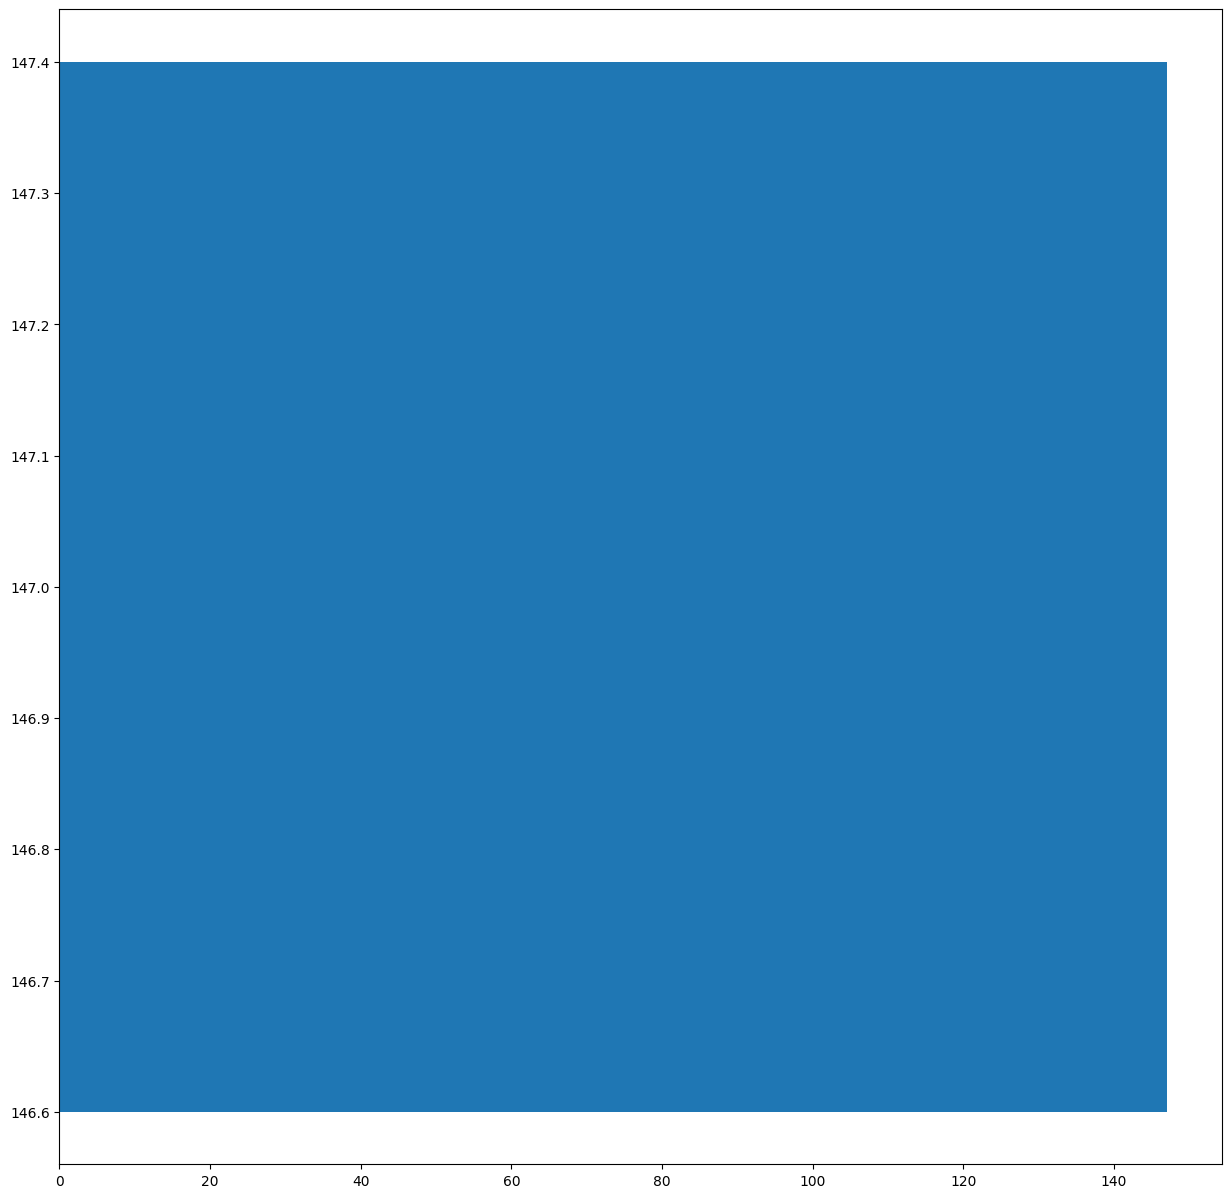

In [43]:
plt.rcParams["figure.figsize"] = [15, 15]

importancia = model.feature_importances_

d = {'x':X_train.columns,'y':importancia}

importancia = pd.DataFrame(d)
importancia = importancia[importancia.y>0.005].count()
ax = plt.barh(importancia.x,importancia.y)

 ## Tunning

In [54]:
import lightgbm as lgb
from sklearn.model_selection import GridSearchCV

param_test1 = {
    "max_depth": range(10,21,2),
    "min_child_weight" : range(10,21,2)
}

gsearch1 = GridSearchCV(estimator = lgb.LGBMRegressor(n_estimators=2000, max_depth= 14,min_child_weight = 15), 
                        param_grid = param_test1,
                        n_jobs=3,
                        cv=3,
                        return_train_score=True,
                        verbose=10)

gsearch1.fit(X_train,y_train)

gsearch1.best_params_, gsearch1.best_score_

Fitting 3 folds for each of 36 candidates, totalling 108 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   2 tasks      | elapsed:  2.0min
[Parallel(n_jobs=3)]: Done   7 tasks      | elapsed:  4.3min
[Parallel(n_jobs=3)]: Done  12 tasks      | elapsed:  8.1min
[Parallel(n_jobs=3)]: Done  19 tasks      | elapsed: 12.1min
[Parallel(n_jobs=3)]: Done  26 tasks      | elapsed: 15.7min
[Parallel(n_jobs=3)]: Done  35 tasks      | elapsed: 20.6min
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed: 26.2min
[Parallel(n_jobs=3)]: Done  55 tasks      | elapsed: 33.3min
[Parallel(n_jobs=3)]: Done  66 tasks      | elapsed: 39.7min
[Parallel(n_jobs=3)]: Done  79 tasks      | elapsed: 47.5min
[Parallel(n_jobs=3)]: Done  92 tasks      | elapsed: 54.6min
[Parallel(n_jobs=3)]: Done 108 out of 108 | elapsed: 63.8min finished


({'max_depth': 14, 'min_child_weight': 10}, 0.8163938827286209)

In [55]:
pd.DataFrame(gsearch1.cv_results_)


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_min_child_weight,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,79.967178,12.909894,26.355807,7.581311,10,10,"{'max_depth': 10, 'min_child_weight': 10}",0.816471,0.813283,0.813495,0.814416,0.001456,31
1,82.958766,9.559553,29.890658,9.861749,10,12,"{'max_depth': 10, 'min_child_weight': 12}",0.816471,0.813283,0.813495,0.814416,0.001456,31
2,81.792402,9.935518,28.869326,3.583335,10,14,"{'max_depth': 10, 'min_child_weight': 14}",0.816471,0.813283,0.813495,0.814416,0.001456,31
3,72.970745,11.496923,20.502733,6.620329,10,16,"{'max_depth': 10, 'min_child_weight': 16}",0.816471,0.813283,0.813495,0.814416,0.001456,31
4,83.547832,10.258654,27.113737,6.902744,10,18,"{'max_depth': 10, 'min_child_weight': 18}",0.816471,0.813283,0.813495,0.814416,0.001456,31
5,73.801501,13.206338,20.354792,6.789688,10,20,"{'max_depth': 10, 'min_child_weight': 20}",0.816471,0.813283,0.813495,0.814416,0.001456,31
6,81.628121,10.253404,23.821714,6.101398,12,10,"{'max_depth': 12, 'min_child_weight': 10}",0.817502,0.812926,0.814121,0.814850,0.001938,25
7,82.064519,14.665681,25.367056,6.747873,12,12,"{'max_depth': 12, 'min_child_weight': 12}",0.817502,0.812926,0.814121,0.814850,0.001938,25
8,79.865702,12.428195,22.907196,4.465648,12,14,"{'max_depth': 12, 'min_child_weight': 14}",0.817502,0.812926,0.814121,0.814850,0.001938,25
9,82.611451,12.601588,18.344129,2.531889,12,16,"{'max_depth': 12, 'min_child_weight': 16}",0.817502,0.812926,0.814121,0.814850,0.001938,25


In [56]:
predecir(gsearch1,X_train,y_train,X_test,y_test)

Entrenamiento: 90.6091%
Testeo: 82.2264%.
Mean abs error: 540587.2892.


array([3482425.95813658, 1879096.75149996, 6613556.68276304, ...,
       1744492.17376268, 2599370.92107758, 1235902.3836734 ])

## Submission

In [57]:
df_test = pd.read_csv('../data/test.csv')

In [58]:
df_test['fecha'] = pd.to_datetime(df_test['fecha'], errors='coerce')
df_test['anio'] = df_test['fecha'].dt.year
df_test["mes"] = df_test['fecha'].dt.month
df_test["dia"] = df_test['fecha'].dt.day
df_test['fecha'] = df_test['fecha'].astype(int) / 10**9

df_test = df_test.drop(columns=["lat","lng"])

df_test["descripcion"] = df_test["descripcion"].fillna("")
df_test["titulo"] = df_test["titulo"].fillna("")

In [59]:
def contiene(df, columna, palabra):
    return df[columna].str.contains(palabra).astype(int)

In [60]:
def contiene_alguna(df, columna, palabras):
    result = df[columna].apply(lambda x: 0)
    for palabra in palabras:
        result = result | contiene(df, columna, palabra)
        
    return result    

In [61]:
df = df_test.copy()

In [62]:
# del wordcloud
df["palabra_hermosa"] = contiene_alguna(df, "descripcion", ["hermosa", "bonita", "bonito", "linda", "cholula", "cholulo", "preciosa", "precioso"]) | contiene_alguna(df, "titulo", ["hermosa", "bonita", "bonito", "linda", "cholula", "cholulo", "precioso", "preciosa"])
df["palabra_excelente"] = contiene_alguna(df, "descripcion", ["excelente", "excelentes"]) | contiene_alguna(df, "titulo", ["excelente", "excelentes"])
df["palabra_mejor"] = contiene_alguna(df, "descripcion", ["mejor", "mejores"]) | contiene_alguna(df, "titulo", ["mejor", "mejores"])
df["palabra_grande"] = contiene_alguna(df, "descripcion", ["grande", "gran", "amplia", "amplias", "amplio", "amplios"]) | contiene_alguna(df, "titulo", ["grande", "gran", "amplia", "amplias", "amplio", "amplios"])
df["palabra_equipada"] = contiene_alguna(df, "descripcion", ["equipada", "equipado", "completa", "completo"]) | contiene_alguna(df, "descripcion", ["equipada", "equipado", "completa", "completo"])
df["palabra_vestidor"] = contiene_alguna(df, "descripcion", ["vestidor", "closet"]) | contiene_alguna(df, "titulo", ["vestidor", "closet"])
df["palabra_credito"] = contiene_alguna(df, "descripcion", ["credito", "crédito", "créditos", "creditos", "banco", "banca", "bancario", "bancarios", "hipoteca"]) | contiene_alguna(df, "titulo", ["credito", "crédito", "créditos", "creditos", "banco", "banca", "bancario", "bancarios", "hipoteca"])
df["palabra_privada"] = contiene_alguna(df, "descripcion", ["privada", "privado"]) | contiene_alguna(df, "titulo", ["privada", "privado"])
df["palabra_bodega"] = contiene_alguna(df, "descripcion", ["bodega"]) | contiene_alguna(df, "titulo", ["bodega"])
df["palabra_club"] = contiene_alguna(df, "descripcion", ["club"]) | contiene_alguna(df, "titulo", ["club"])
df["palabra_cerrada"] = contiene_alguna(df, "descripcion", ["cerrada", "cerrado"]) | contiene_alguna(df, "titulo", ["cerrada", "cerrado"])
df["palabra_jardin"] = contiene_alguna(df, "descripcion", ["jardin", "jardín", "garden", "patio"]) | contiene_alguna(df, "titulo", ["jardin", "jardín", "garden", "patio"])
df["palabra_oportunidad"] = contiene_alguna(df, "descripcion", ["oportunidad"]) | contiene_alguna(df, "titulo", ["oportunidad"])
df["palabra_tv"] = contiene_alguna(df, "descripcion", ["tv", "tele", "television", "televisión", "televisor"]) | contiene_alguna(df, "titulo", ["tv", "tele", "television", "televisión", "televisor"])
df["palabra_juegos"] = contiene_alguna(df, "descripcion", ["juego"]) | contiene_alguna(df, "titulo", ["juego"])
df["palabra_niño"] = contiene_alguna(df, "descripcion", ["niño", "niña", "infantil"]) | contiene_alguna(df, "titulo", ["niño", "niña", "infantil"])
df["palabra_transporte"] = contiene_alguna(df, "descripcion", ["transporte"]) | contiene_alguna(df, "titulo", ["transporte"])
df["palabra_estudio"] = contiene_alguna(df, "descripcion", ["estudio"]) | contiene_alguna(df, "titulo", ["estudio"])
df["palabra_terraza"] = contiene_alguna(df, "descripcion", ["terraza"]) | contiene_alguna(df, "titulo", ["terraza"])
df["palabra_balcon"] = contiene_alguna(df, "descripcion", ["balcón", "balcon"]) | contiene_alguna(df, "titulo", ["balcón", "balcon"])
df["palabra_lote"] = contiene_alguna(df, "descripcion", ["lote", "terreno"]) | contiene_alguna(df, "titulo", ["lote", "terreno"])
df["palabra_fraccionamiento"] = contiene_alguna(df, "descripcion", ["fraccionamiento", "fracc"]) | contiene_alguna(df, "titulo", ["fraccionamiento", "fracc"])
df["palabra_local"] = contiene_alguna(df, "descripcion", ["local", "tienda", "comercial"]) | contiene_alguna(df, "titulo", ["local", "tienda", "comercial"])
df["palabra_seguridad"] = contiene_alguna(df, "descripcion", ["vigilancia", "vigilador", "seguridad", "guardia"]) | contiene_alguna(df, "titulo", ["vigilancia", "vigilador", "seguridad", "guardia"])
df["palabra_garage"] = contiene_alguna(df, "descripcion", ["garage", "auto", "estacionamiento"]) | contiene_alguna(df, "titulo", ["garage", "auto", "estacionamiento"])
df["palabra_centro"] = contiene_alguna(df, "descripcion", ["centro", "central", "cercano", "cercania", "minuto"]) | contiene_alguna(df, "titulo", ["centro", "central", "cercano", "cercania", "minuto"])
df["palabra_techada"] = contiene_alguna(df, "descripcion", ["techada", "techado", "roof"]) | contiene_alguna(df, "titulo", ["techada", "techado", "roof"])
df["palabra_estancia"] = contiene_alguna(df, "descripcion", ["estancia"]) | contiene_alguna(df, "titulo", ["estancia"])
df["palabra_alberca"] = contiene_alguna(df, "descripcion", ["alberca"]) | contiene_alguna(df, "titulo", ["alberca"])
df["palabra_servicios"] = contiene_alguna(df, "descripcion", ["servicios"]) | contiene_alguna(df, "titulo", ["servicios"])
df["palabra_servicio"] = contiene_alguna(df, "descripcion", ["servicio"]) | contiene_alguna(df, "titulo", ["servicio"])
df["palabra_estilo"] = contiene_alguna(df, "descripcion", ["estilo"]) | contiene_alguna(df, "titulo", ["estilo"])
df["palabra_frente"] = contiene_alguna(df, "descripcion", ["frente"]) | contiene_alguna(df, "titulo", ["frente"])
df["palabra_vista"] = contiene_alguna(df, "descripcion", ["vista"]) | contiene_alguna(df, "titulo", ["vista"])
df["palabra_visitas"] = contiene_alguna(df, "descripcion", ["visita"]) | contiene_alguna(df, "titulo", ["visita"])
df["palabra_parque"] = contiene_alguna(df, "descripcion", ["parque", "plaza", "verde"]) | contiene_alguna(df, "titulo", ["parque", "plaza", "verde"])
df["palabra_areas"] = contiene_alguna(df, "descripcion", ["area", "área"]) | contiene_alguna(df, "titulo", ["area", "área"])
df["palabra_estrenar"] = contiene_alguna(df, "descripcion", ["estrenar", "estreno", "estrene"]) | contiene_alguna(df, "titulo", ["estrenar", "estreno", "estrene"])
df["palabra_infonavit"] = contiene_alguna(df, "descripcion", ["infonavit"]) | contiene_alguna(df, "titulo", ["infonavit"])
df["palabra_residencial"] = contiene_alguna(df, "descripcion", ["residencia"]) | contiene_alguna(df, "titulo", ["residencia"])
df["palabra_escuela"] = contiene_alguna(df, "descripcion", ["escuela", "colegio", "educacion", "educación", "uni", "universidad", "facultad"]) | contiene_alguna(df, "titulo", ["escuela", "colegio", "educacion", "educación", "uni", "universidad", "facultad"])
df["palabra_exclusivo"] = contiene_alguna(df, "descripcion", ["exclusivo", "exclusividad"]) | contiene_alguna(df, "titulo", ["exclusivo", "exclusividad"])
df["palabra_lujo"] = contiene_alguna(df, "descripcion", ["lujo"]) | contiene_alguna(df, "titulo", ["lujo"])
df["palabra_esquina"] = contiene_alguna(df, "descripcion", ["esquina"]) | contiene_alguna(df, "titulo", ["esquina"])
df["palabra_refaccion"] = contiene_alguna(df, "descripcion", ["refaccion", "refacción", "reacondicionado", "remodelada", "remodelado"]) | contiene_alguna(df, "titulo", ["refaccion", "refacción", "reacondicionado", "remodelada", "remodelado"])
df["palabra_country"] = contiene_alguna(df, "descripcion", ["country"]) | contiene_alguna(df, "titulo", ["country"])
df["palabra_barra"] = contiene_alguna(df, "descripcion", ["barra"]) | contiene_alguna(df, "titulo", ["barra"])
df["palabra_lavado"] = contiene_alguna(df, "descripcion", ["lavado"]) | contiene_alguna(df, "titulo", ["lavado"])
df["palabra_renta"] = contiene_alguna(df, "descripcion", ["renta", "alquiler", "alquilar"]) | contiene_alguna(df, "titulo", ["renta", "alquiler", "alquilar"])
df["palabra_super"] = contiene_alguna(df, "descripcion", ["super"]) | contiene_alguna(df, "titulo", ["super"])
df["palabra_lago"] = contiene_alguna(df, "descripcion", ["lago"]) | contiene_alguna(df, "titulo", ["lago"])
df["palabra_bosque"] = contiene_alguna(df, "descripcion", ["bosque", "arbol", "árbol"]) | contiene_alguna(df, "titulo", ["bosque", "arbol", "árbol"])
df["palabra_avenida"] = contiene_alguna(df, "descripcion", ["av", "avenida"]) | contiene_alguna(df, "titulo", ["av", "avenida"])
df["palabra_hospital"] = contiene_alguna(df, "descripcion", ["hospital", "medicina", "medico", "médico", "farmacia"]) | contiene_alguna(df, "titulo", ["hospital", "medicina", "medico", "médico", "farmacia"])
df["palabra_pileta"] = contiene_alguna(df, "descripcion", ["pileta", "piscina", "jacuzzi"]) | contiene_alguna(df, "titulo", ["pileta", "piscina", "jacuzzi"])
df["palabra_solarium"] = contiene_alguna(df, "descripcion", ["solarium"]) | contiene_alguna(df, "titulo", ["solarium"])
df["palabra_gas"] = contiene_alguna(df, "descripcion", ["gas", "estufa"]) | contiene_alguna(df, "titulo", ["gas", "estufa"])




In [63]:
print(f"Train shapes: X={X_train_submit.shape} y={y_train.shape}")
print(f"Test  shapes: X={df.shape}  ")

Train shapes: X=(180000, 80) y=(180000,)
Test  shapes: X=(60000, 80)  


In [64]:
#X_train_submit = preprocess(X_train_submit, OHE, BE, 'train')
df = preprocess(df, OHE, BE, 'test')

['tipodepropiedad', 'provincia', 'ciudad', 'idzona']

In [65]:
print(f"Train shapes: X={X_train_submit.shape} y={y.shape}")
print(f"Test  shapes: X={df.shape}")

Train shapes: X=(180000, 80) y=(240000,)
Test  shapes: X=(60000, 154)


In [66]:
submit_prediction = gsearch1.predict( df )

In [42]:
#cols_diff = []
#ft = X_train.columns.values
#fs = df.columns.values
#for feat in fs:
#    if feat not in ft:
#        cols_diff.append(feat)
        
#display(cols_diff)        

In [43]:
#pd.concat([df_test[['id']], pd.Series(submit_prediction)], axis=1).rename(columns={0:"target"}).to_csv("../data/submission13.csv", index=False)

In [67]:
from submission_helper import submission_output

output = submission_output(df_test, submit_prediction)

output.to_csv('../data/submission16.csv', index=False)